In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=2401fa8e8263a53c985ca1ba13cb462ca11b8aea7366d9302cbaff545ab0adfe
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
# import the necessary packages
import tensorflow as tf
import gc
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from datetime import datetime
# %load_ext tensorboard

from __future__ import absolute_import, division, print_function, unicode_literals
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)


Num GPUs Available:  0


[]

In [4]:
"""## Build Dataset"""

dataset_path = './out'
log_path = './logs'
df = pd.DataFrame(columns =['class', 'directory'])  

for dirpath, dirnames, filenames in os.walk('/kaggle/input/covid-pneumonia-normal-chest-xray-images/NORMAL'):
    for filename in filenames:
        df.loc[-1] = ["normal", ('NORMAL/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index() 
for dirpath, dirnames, filenames in os.walk('/kaggle/input/covid-pneumonia-normal-chest-xray-images/COVID'):
    for filename in filenames:
        df.loc[-1] = ["covid", ('COVID/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index() 
for dirpath, dirnames, filenames in os.walk('/kaggle/input/covid-pneumonia-normal-chest-xray-images/PNEUMONIA'):
    for filename in filenames:
        df.loc[-1] = ["pneumonia", ('PNEUMONIA/' + filename)] 
        df.index = df.index + 1 
        df = df.sort_index()

df_y = df['class']
df_x = df['directory']

print(df_x.shape)
print(df_y.shape)


(5228,)
(5228,)


In [5]:
"""## Data preprocessing"""

X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, stratify=df_y, test_size=0.20, random_state=7)

df_x, df_y = X_train, Y_train

test = pd.concat([X_test, Y_test], axis = 1)
test.head()

# used to copy files according to each fold
def copy_images(df, directory):
    
    # input and output directory
    input_path = "/kaggle/input/covid-pneumonia-normal-chest-xray-images"     
    output_path = "out/" + directory

    # remove all files from previous fold
    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    # create folder for files from this fold
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # create subfolders for each class
    classs=['NORMAL','COVID','PNEUMONIA']
    for c in classs:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)
        
    # copy files
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        path_to = "{}/{}".format(output_path, row['directory'])
        shutil.copy(path_from, path_to)
#         print(path_to)

copy_images(test, 'test')

print(len(os.listdir('./out/test/NORMAL')))
print(len(os.listdir('./out/test/COVID')))
print(len(os.listdir('./out/test/PNEUMONIA')))

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=r"./out/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)


361
325
360
Found 1046 images belonging to 3 classes.


In [6]:
"""## Model"""

class_to_label_map = {'pneumonia' : 2, 'covid' : 1, 'normal' : 0}

def get_model():
    # Create Model..........................................
    
    # Input layer
    baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
        layer.trainable = False
    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)

    
    # FC layer
    x = Flatten(name="flatten")(x)
    
    # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    
    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(lr=0.01, clipvalue=100)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model


In [7]:
"""### Training"""

from math import floor
from time import time
N_FOLDS = 1
EPOCHS = 5
INIT_LR = 2e-4
T_BS = 32
V_BS = 32
decay_step = 1
decay_rate = 0.95

log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [ModelCheckpoint(filepath='best_lstm_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step))), 
			 tensorboard_callback]

submission_predictions = []
skf = StratifiedKFold(n_splits = 2, random_state = 7, shuffle = True)

for epoch, (train_index, val_index) in enumerate(skf.split(df_x, df_y)):
    x_train, x_val = df_x.iloc[train_index], df_x.iloc[val_index]
    y_train, y_val = df_y.iloc[train_index], df_y.iloc[val_index]
    
    print(y_train.value_counts())
    print(y_val.value_counts())

    train = pd.concat([x_train, y_train], axis=1)
    val = pd.concat([x_val, y_val], axis = 1)
    
    # copy the images according to the fold
    copy_images(train, 'train')
    copy_images(val, 'val')
    
    print('Running fold '+ str(epoch+1))
    
    # CREATE MODEL
    model = get_model()
    # model.summary()
    
    # Load Model Weights
    if epoch != 0:
        model.load_weights('best_lstm_model.h5') 
    
    train_generator = train_datagen.flow_from_directory(
        directory=r"./out/train/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    valid_generator = val_datagen.flow_from_directory(
        directory=r"./out/val/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=16,
        class_mode="categorical",
        shuffle=True,
        seed=42
    )
    
    startTrain = time()
    history = model.fit_generator(
                generator=train_generator,
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                validation_data=valid_generator,
                validation_steps=valid_generator.n//valid_generator.batch_size,
                epochs=EPOCHS,
                callbacks=callbacks
    )
    print(time()-startTrain)
    
    test_generator.reset()
    startTest = time()
    predY=model.predict_generator(
            test_generator,
            steps=test_generator.n//test_generator.batch_size,
            verbose=1)
    print(time()-startTest)
    
    if epoch >= 1:
        submission_predictions.append(predY)
        
    testY = test_generator.classes
    confusion__matrix=confusion_matrix(testY, np.argmax(predY, axis = -1))
    cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4))
    print (cr)
    print(confusion__matrix)
    
    model.save('best_lstm_model.h5') 
    
    del history
    del model
    gc.collect()



class
normal       720
pneumonia    720
covid        651
Name: count, dtype: int64
class
normal       721
pneumonia    720
covid        650
Name: count, dtype: int64
Running fold 1
80134624/80134624 [==============================] - 0s 0us/step
Found 2091 images belonging to 3 classes.
Found 2091 images belonging to 3 classes.


/tmp/ipykernel_42/2437094691.py:67: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
130/130 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.8573
Epoch 1: val_loss improved from inf to 5.71983, saving model to best_lstm_model.h5
130/130 [==============================] - 1655s 13s/step - loss: 0.9891 - accuracy: 0.8573 - val_loss: 5.7198 - val_accuracy: 0.3111 - lr: 2.0000e-04
Epoch 2/5
130/130 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.9046
Epoch 2: val_loss improved from 5.71983 to 1.91667, saving model to best_lstm_model.h5
130/130 [==============================] - 1680s 13s/step - loss: 0.3662 - accuracy: 0.9046 - val_loss: 1.9167 - val_accuracy: 0.3971 - lr: 1.9000e-04
Epoch 3/5
130/130 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9229
Epoch 3: val_loss improved from 1.91667 to 0.67630, saving model to best_lstm_model.h5
130/130 [==============================] - 1675s 13s/step - loss: 0.2583 - accuracy: 0.9229 - val_loss: 0.6763 - val_accuracy: 0.7207 - lr: 1.8050e-04
Epoch

/tmp/ipykernel_42/2437094691.py:79: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predY=model.predict_generator(


1046/1046 [==============================] - 411s 392ms/step
442.7977123260498
{'pneumonia': {'precision': 0.9875389408099688, 'recall': 0.9753846153846154, 'f1-score': 0.9814241486068113, 'support': 325}, 'covid': {'precision': 0.9755244755244755, 'recall': 0.7728531855955678, 'f1-score': 0.8624420401854714, 'support': 361}, 'normal': {'precision': 0.8018223234624146, 'recall': 0.9777777777777777, 'f1-score': 0.881101376720901, 'support': 360}, 'accuracy': 0.9063097514340345, 'macro avg': {'precision': 0.9216285799322863, 'recall': 0.908671859585987, 'f1-score': 0.9083225218377279, 'support': 1046}, 'weighted avg': {'precision': 0.9194746920401957, 'recall': 0.9063097514340345, 'f1-score': 0.9058326199079285, 'support': 1046}}
[[317   2   6]
 [  1 279  81]
 [  3   5 352]]


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


class
normal       721
pneumonia    720
covid        650
Name: count, dtype: int64
class
normal       720
pneumonia    720
covid        651
Name: count, dtype: int64
Running fold 2
Found 2091 images belonging to 3 classes.
Found 2091 images belonging to 3 classes.


/tmp/ipykernel_42/2437094691.py:67: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
130/130 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9306
Epoch 1: val_loss improved from 0.24832 to 0.06796, saving model to best_lstm_model.h5
130/130 [==============================] - 1696s 13s/step - loss: 0.2285 - accuracy: 0.9306 - val_loss: 0.0680 - val_accuracy: 0.9745 - lr: 2.0000e-04
Epoch 2/5
130/130 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9398
Epoch 2: val_loss did not improve from 0.06796
130/130 [==============================] - 1696s 13s/step - loss: 0.2119 - accuracy: 0.9398 - val_loss: 0.0828 - val_accuracy: 0.9702 - lr: 1.9000e-04
Epoch 3/5
130/130 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9499
Epoch 3: val_loss improved from 0.06796 to 0.05879, saving model to best_lstm_model.h5
130/130 [==============================] - 1705s 13s/step - loss: 0.1644 - accuracy: 0.9499 - val_loss: 0.0588 - val_accuracy: 0.9817 - lr: 1.8050e-04
Epoch 4/5
130/130 [======================

/tmp/ipykernel_42/2437094691.py:79: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predY=model.predict_generator(


1046/1046 [==============================] - 412s 393ms/step
442.51432061195374
{'pneumonia': {'precision': 0.9935897435897436, 'recall': 0.9538461538461539, 'f1-score': 0.9733124018838304, 'support': 325}, 'covid': {'precision': 0.9473684210526315, 'recall': 0.9473684210526315, 'f1-score': 0.9473684210526315, 'support': 361}, 'normal': {'precision': 0.9302949061662198, 'recall': 0.9638888888888889, 'f1-score': 0.946793997271487, 'support': 360}, 'accuracy': 0.9550669216061185, 'macro avg': {'precision': 0.9570843569361983, 'recall': 0.9550344879292249, 'f1-score': 0.9558249400693164, 'support': 1046}, 'weighted avg': {'precision': 0.955853568725149, 'recall': 0.9550669216061185, 'f1-score': 0.9552317109273233, 'support': 1046}}
[[310   8   7]
 [  0 342  19]
 [  2  11 347]]


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


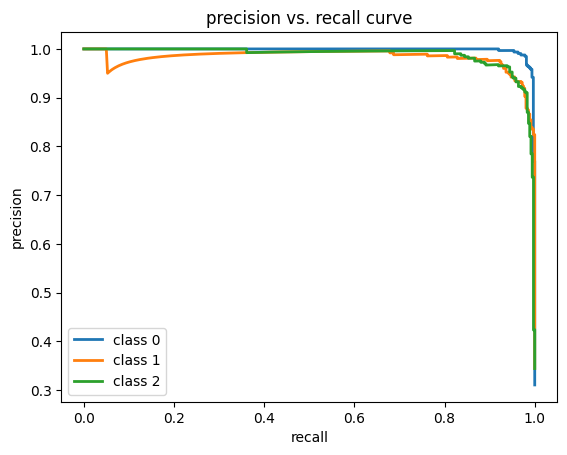

<Figure size 640x480 with 0 Axes>

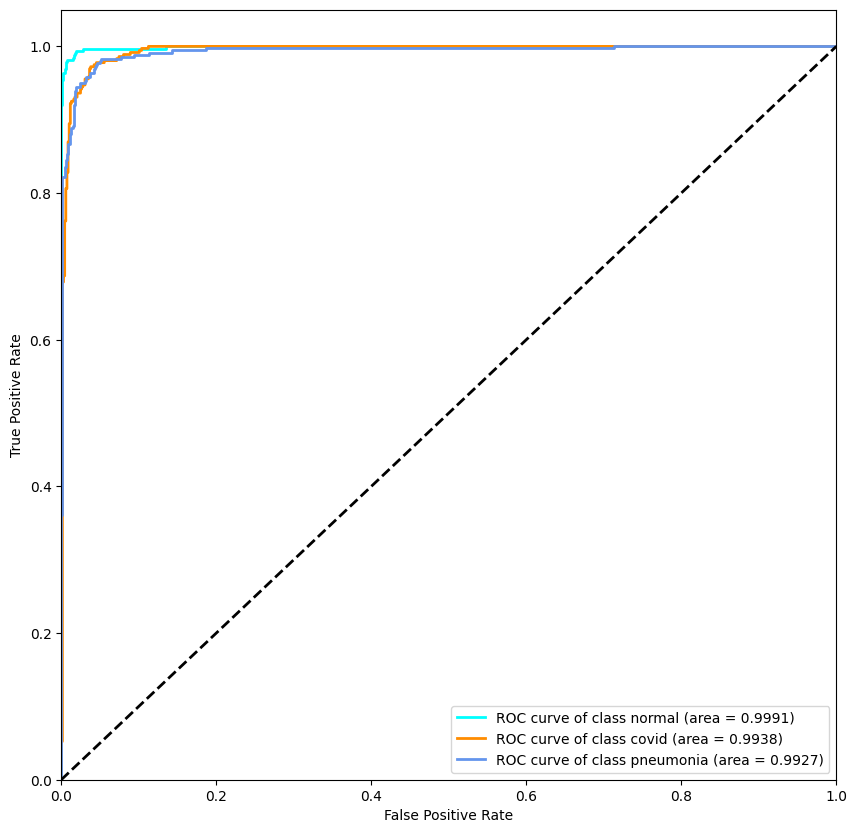

In [8]:
"""### Evaluation"""

predY = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])

# plot precision-recall-curve
precision = dict()
recall = dict()

y_test_dummies = pd.get_dummies(testY, drop_first=False).values
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i], predY[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()
plt.savefig('prc.png')

# plot ROC
import seaborn as sns
class_to_label_map = ['normal', 'covid', 'pneumonia']

def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(10, 10))
    lw = 2

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_to_label_map[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc(testY, predY, n_classes=3, figsize=(10, 10))


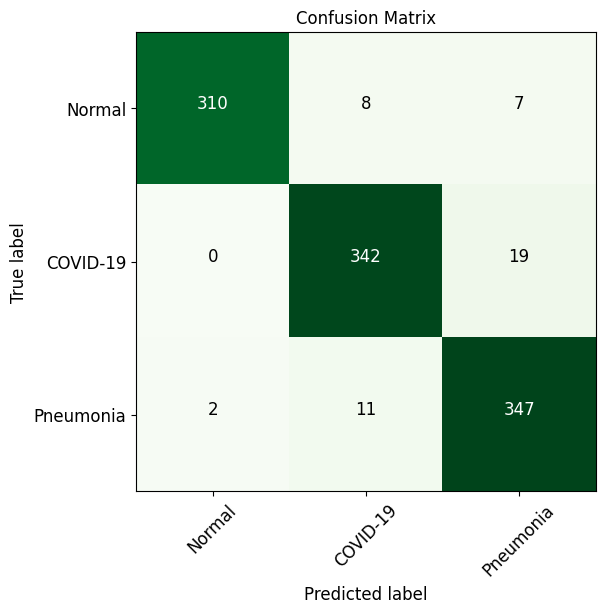

              precision    recall  f1-score   support

      normal     0.9936    0.9538    0.9733       325
       covid     0.9474    0.9474    0.9474       361
   pneumonia     0.9303    0.9639    0.9468       360

    accuracy                         0.9551      1046
   macro avg     0.9571    0.9550    0.9558      1046
weighted avg     0.9559    0.9551    0.9552      1046



In [9]:
"""#### Confusion matrix"""

cm_mat = confusion_matrix(testY, np.argmax(predY, axis = -1))

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'larger')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize = 'larger')
        plt.yticks(tick_marks, target_names, fontsize = 'larger')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 'larger')
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 'larger')


    plt.tight_layout()
    plt.ylabel('True label', fontsize = 'larger')
    plt.xlabel('Predicted label', fontsize = 'larger')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm_mat, 
                      normalize = False,
                      target_names = ['Normal', 'COVID-19', 'Pneumonia'],
                      title        = "Confusion Matrix")

print(classification_report(testY, np.argmax(predY, axis = -1), target_names = ['normal', 'covid', 'pneumonia'], digits=4))